# <span style="color:#ffb366">Zaawansowana Klasyfikacja</span>
* Mamy zbiór win, dostajemy parametry danego wina(ph,alkohol,gęstość itp)
* Chcemy ocenić dane wino na podstawie powyższych danych

> 📝 <span style="color:#b3b3cc">Komentarz: </span> W ramach komentarza wspomne już teraz, że najlepiej na tym zbiorze robić regresję, klasyfikacja nie jest łatwa, dodatkowo mógłbym uprościć dane i dać wina "dobre" i "złe", ale chciałem pokusić się o przewidzenie ocen(miedzy innymi dlatego też, że klasy są tak rozłożone, że tylko to ma sens)

In [2]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from keras.src.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, PowerTransformer, RobustScaler, OneHotEncoder, PolynomialFeatures, \
    MinMaxScaler
from collections import Counter

import keras.src.callbacks
from keras.src.layers import Dense, Dropout
from keras import models, Input
from keras_tuner import RandomSearch, BayesianOptimization
from sklearn.tree import DecisionTreeClassifier
from tensorflow.python.keras.utils.np_utils import to_categorical
from typing_extensions import override

## <span style="color:#ffb366">Funkcje pomocnicze</span>
* funkcje do wykresów historii, rozkładów danych
* funkcję do tworzenia kerasowych modelów(ja akurat używałem tylko FFNN)

### Rozkład klas w wektorze

In [3]:
def klasy_slupki(y, name="Rozkład"):
    class_counts = Counter(y)
    
    # Przygotowanie danych do wykresu
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    
    l_sort= sorted(zip(labels,counts), key=lambda x: x[0], reverse=False)
    labels = [x[0] for x in l_sort]
    counts = [x[1] for x in l_sort]
    # Tworzenie wykresu słupkowego
    plt.bar(labels, counts,color='skyblue')
    
    # Dodanie etykiet i tytułu
    plt.xlabel("Klasy")
    plt.ylabel("Liczba wystąpień")
    plt.title(name)
    # Wyświetlenie wykresu
    plt.show()

### Pokazywanie rozkładu danych

In [4]:
def rozklad_danych(X):
    fig, axs = plt.subplots(nrows=6, ncols=2)
    for ax, col in zip(axs.flatten(),X.columns):
        ax.hist(X[col],bins=50)
        ax.set_title(col)
    fig.tight_layout()

### Rozkład procentowy klas w naszym wektorze

In [5]:
def klasy_procent_plot(y, y1 = None, name="Procentowy rozkład zmiennej"):
    if y1 is None:
        cnt = Counter(y)
        keys,values = zip(*sorted(zip(cnt.keys(), cnt.values())))
        fig, ax = plt.subplots()
        ax.pie(values, labels=keys, autopct='%1.1f%%', pctdistance=1.4)
        fig.suptitle(name)
    else:
        cnt = Counter(y)
        cnt1 = Counter(y1)
        keys,values = zip(*sorted(zip(cnt.keys(), cnt.values()), key=lambda x: x[0], reverse=True))
        keys1,values1 = zip(*sorted(zip(cnt1.keys(), cnt1.values()), key=lambda x: x[0], reverse=True))
        
        fig, ax = plt.subplots(1,2)
        ax[0].pie(values, labels=keys, autopct='%1.1f%%', pctdistance=1.4)
        ax[1].pie(values1, labels=keys1, autopct='%1.1f%%', pctdistance=1.4)
        fig.suptitle(name)

### Budowanie modelu sieci neuronowej keras (klasyfikator)

In [61]:
from tensorflow.python.keras import regularizers
from keras.api import initializers


def create_model(lay_num=1, lay_neuron=40, dropout=False, activation = 'relu', learning_rate = 0.001):
    optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name="adam",)
    
    model = models.Sequential()
    
    # ============input layer============
    model.add(Input(shape=(11,)))
    
    # ============hidden layers============
    for i in range(lay_num):
        model.add(Dense(lay_neuron, activation = activation, kernel_initializer=initializers.he_normal()))
    
    # ============hidden layers============
    if dropout:
        model.add(Dropout(rate=0.1))
    
    # ============output============
    model.add(Dense(7, activation = 'softmax'))
    
    # ============compiling============
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

### Budowanie modelu sieci neuronowej keras (regresor)

In [60]:
from tensorflow.python.keras import regularizers
from keras.api import initializers


def create_model_regressor(lay_num=1, lay_neuron=40, dropout=False, activation = 'relu', learning_rate = 0.001):
    optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name="adam",)
    
    model = models.Sequential()
    
    # ============input layer============
    model.add(Input(shape=(11,)))
    
    # ============hidden layers============
    for i in range(lay_num):
        model.add(Dense(lay_neuron, activation = activation, kernel_initializer=initializers.he_normal()))
    
    # ============hidden layers============
    if dropout:
        model.add(Dropout(rate=0.1))
    
    # ============output============
    model.add(Dense(1, activation = 'linear'))
    
    # ============compiling============
    model.compile(loss = 'mean_absolute_error', optimizer = optimizer)
    return model

### Szkicowanie historii z modelów kerasa

In [62]:
def plot_history(his, verbose=1):
    # Pobieranie danych
    acc = his.history['accuracy']
    loss = his.history['loss']
    acc_val = his.history['val_accuracy']
    loss_val = his.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Tworzenie figure z dwoma subplotami
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 1]})
    
    # Wykres dokładności
    axes[0].plot(epochs, acc, label="Accuracy")
    if acc_val:
        axes[0].plot(epochs, acc_val, label="Validation Accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(loc='lower right')
    axes[0].set_aspect('auto')  # Automatyczne proporcje wykresu
    
    # Wykres straty
    axes[1].plot(epochs, loss, label="Loss")
    if loss_val:
        axes[1].plot(epochs, loss_val, label="Validation Loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend(loc='upper right')
    axes[1].set_aspect('auto')  # Automatyczne proporcje wykresu
    
    # Dopasowanie layoutu
    plt.tight_layout()
    plt.show()
    
    # Wypisywanie wyników
    if verbose:
        print(f"{'-'*30}\n",f"Accuracy: {acc[-1] if acc else 'N/A'}\n",f"Validation Accuracy: {acc_val[-1] if acc_val else 'N/A'}\n",f"Loss: {loss[-1] if loss else 'N/A'}\n",f"Validation Loss: {loss_val[-1] if loss_val else 'N/A'}\n",f"{'-'*30}")

##  <span style="color:#ffb366">Ładowanie danych</span>

In [6]:
rd = pd.read_csv('./datasets/winequality-red.csv', sep=";")
rd.attrs['title'] = "czerwone wino"
wd = pd.read_csv('./datasets/winequality-white.csv', sep=";")
wd.attrs['title'] = "białe wino"
rwd = pd.concat([rd, wd],axis=0,ignore_index=True)
rwd.attrs['title'] = "połączone wina"

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


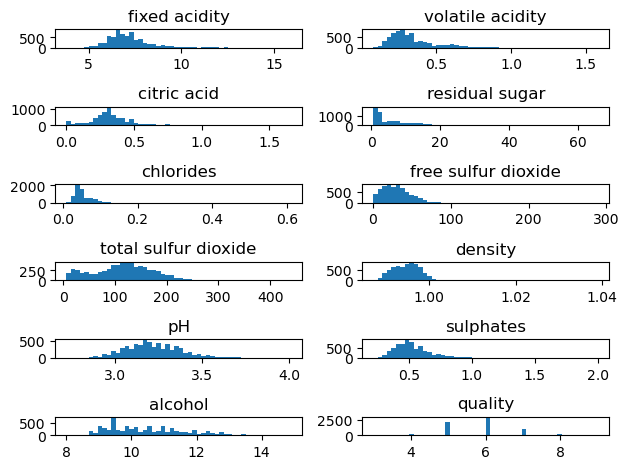

In [7]:
rozklad_danych(rwd)
rwd.describe()

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Widzimy, że dane nie wyglądają źle, ale i tak wymagają drobnego wstępnego przetworzenia :)

##  <span style="color:#ffb366">Ładowanie danych</span>

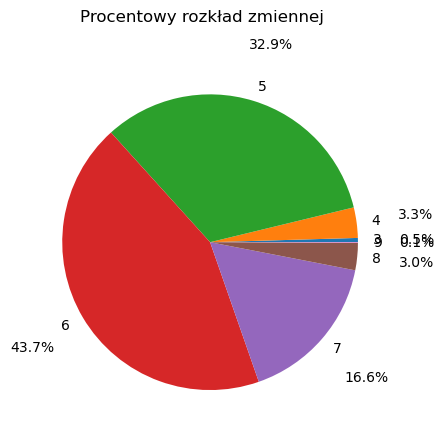

In [10]:
klasy_procent_plot(rwd.quality)

> 📝 <span style="color:#b3b3cc">Komentarz: </span> W tym miejscu warto zaznaczyć, że klasy są bardzo nierównomiernie rozłożone, to powinno (i zobaczymy, że tak będzie) sprawić problemy przy próbie przewidzenia oceny

## <span style="color:#ffb366">Preprocessing danych</span>

In [8]:
from sklearn.utils import compute_class_weight, class_weight
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

rd = pd.read_csv('./datasets/winequality-red.csv', sep=";")
rd.attrs['title'] = "czerwone wino"
wd = pd.read_csv('./datasets/winequality-white.csv', sep=";")
wd.attrs['title'] = "białe wino"
rwd = pd.concat([rd, wd],axis=0,ignore_index=True)
rwd.attrs['title'] = "połączone wina"

y = rwd.pop('quality')
rwd_col = rwd.columns
X = rwd.copy()

transormer = PowerTransformer(method='yeo-johnson')
transormer.fit(X.transpose())
X = pd.DataFrame(transormer.transform(X.transpose()).transpose())
X.columns = rwd_col

transormer = StandardScaler()
transormer.fit(X.transpose())
X = pd.DataFrame(transormer.transform(X.transpose()).transpose())
X.columns = rwd_col

transormer = OrdinalEncoder()
transormer.fit(y.values.reshape(-1,1))
y_trans = pd.Series(transormer.transform(y.values.reshape(-1,1)).flatten())

X_train, X_test, y_train, y_test = train_test_split(X,y_trans, stratify=y_trans, test_size=0.2, shuffle=True)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.656384,-1.029889,-1.052263,0.225136,-1.334674,1.225867,1.695348,-0.555537,0.163154,-0.861741,0.868214
std,0.186651,0.125332,0.134962,0.421742,0.052026,0.216546,0.084045,0.062700,0.113889,0.096154,0.176685
min,0.205127,-1.373113,-1.485841,-0.662968,-1.604428,-0.381433,1.010728,-0.888811,-0.111571,-1.099193,0.516906
25%,0.510446,-1.113490,-1.104738,-0.142567,-1.364189,1.160616,1.671667,-0.601281,0.065193,-0.927424,0.726843
50%,0.627156,-1.061665,-1.034291,0.140710,-1.329839,1.287290,1.706548,-0.567431,0.169554,-0.874089,0.878171
75%,0.753852,-0.981359,-0.972171,0.608646,-1.298847,1.367953,1.740384,-0.510441,0.250234,-0.808635,0.969442
max,1.532207,-0.316667,-0.313236,1.437148,-1.110362,1.626496,1.892575,-0.298638,0.565248,-0.188739,1.603643


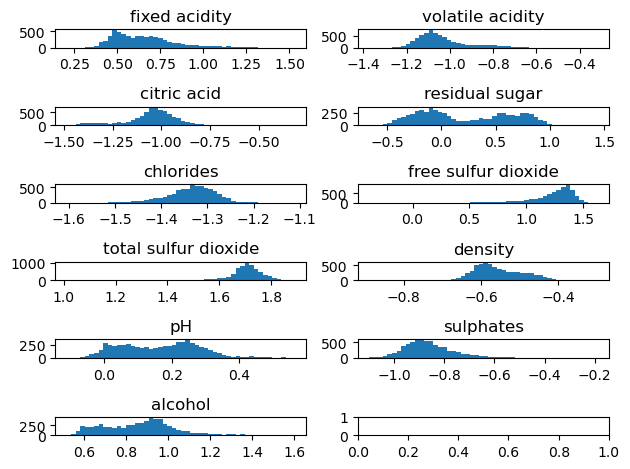

In [12]:
rozklad_danych(X)
X.describe()

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Widzimy, że udało mi się nadać naszym danym rozkładu przypominającego normalny, co więcej zastosowałem skalowanie za pomoca StandardScaler, którego celem jest skalowanie danych w taki sposób aby ich średnia wynosiła 0 oraz odchylenie standardowe równe 1 (przydatne dla modeli liniowych takich jak logistyczna regresja). Dla sieci neuronowych dobrze by było aby dane były z przedziału od 0 do 1, ale widzimy, że dane już są w takim przedziale(oczywiście po przesunięciu ich poza zero, to będę robił później, tak samo dobrze by było grzyby dużo wartości nie znajdywało się w zerze, sieci neuronowe raczej lubią wartości większe od zera). W późniejszych fazach będę używał ocen, które są przesunięte do zera czyli, zamiast ocen w zakresie 3-9, będą oceny w zakresie 0-6

## <span style="color:#ffb366">Trenowanie i obliczenie</span>

### <span style="color:#ff668c">Logistyczna regresja</span>

In [86]:
model = LogisticRegression(max_iter=5000, solver='saga')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Dokładność modelu wynosi {model.score(X_test, y_test):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Dokładność modelu wynosi 0.51385
RMSE: 0.825553427428208


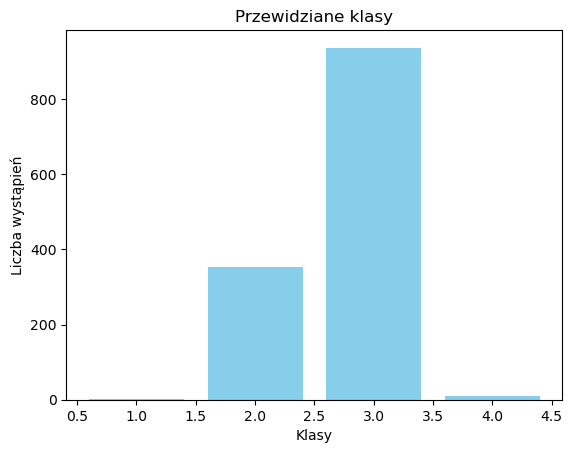

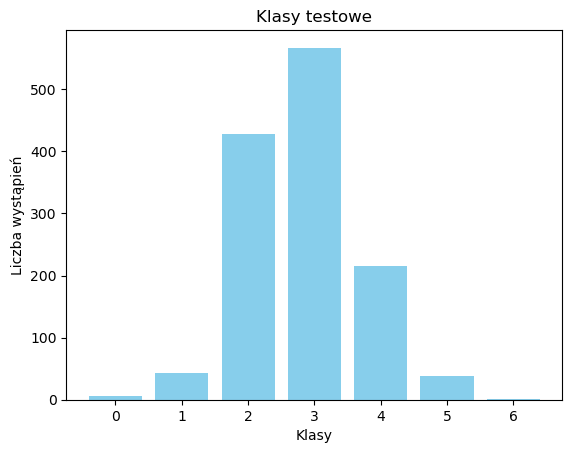

In [87]:
klasy_slupki(y_pred, "Przewidziane klasy")
klasy_slupki(y_test, "Klasy testowe")

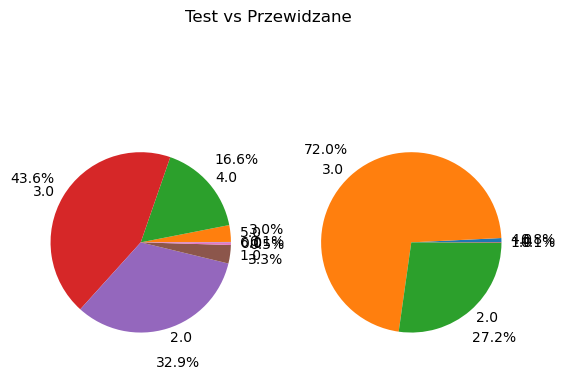

In [88]:
klasy_procent_plot(y_test, y_pred, "Test vs Przewidzane")

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Widzimy, że nie wygląda to dobrze, istotnym problemem tutaj może być złożoność modelu, więc spróbujmy zwiększyć stopień naszego wielomianu

In [44]:
best_degree = (0,-1,None)
for degree in range(1,5):
    transformer = PolynomialFeatures(degree = degree, include_bias = False)
    transformer.fit(X_train.values)
    X_train_trans = transformer.transform(X_train.values)

    model = LogisticRegression(max_iter=3000,solver='sag')
    model.fit(X_train_trans, y_train)

    X_test_trans = transformer.transform(X_test.values)
    score = model.score(X_test_trans, y_test)
    print(f"Wynik dokładności dla modelu o stopniu {degree}: {score:.5f}")
    if best_degree[1] < score:
        best_degree = (degree,score,model)

Wynik dokładności dla modelu o stopniu 1: 0.51000
Wynik dokładności dla modelu o stopniu 2: 0.51923
Wynik dokładności dla modelu o stopniu 3: 0.54154
Wynik dokładności dla modelu o stopniu 4: 0.56231


In [45]:
transformer = PolynomialFeatures(degree = best_degree[0], include_bias = False)
transformer.fit(X_train.values)
X_train_trans = transformer.transform(X_train.values)

model = best_degree[2]

X_test_trans = transformer.transform(X_test.values)
score = model.score(X_test_trans, y_test)
y_pred = model.predict(X_test_trans)
print(f"Wynik dokładności dla modelu o stopniu {best_degree[0]}: {score:.5f}")
print(f"Wynik błędu dla modelu o stopniu {best_degree[0]}: {root_mean_squared_error(y_pred,y_test):.5f}")

Wynik dokładności dla modelu o stopniu 4: 0.56231
Wynik błędu dla modelu o stopniu 4: 0.77061


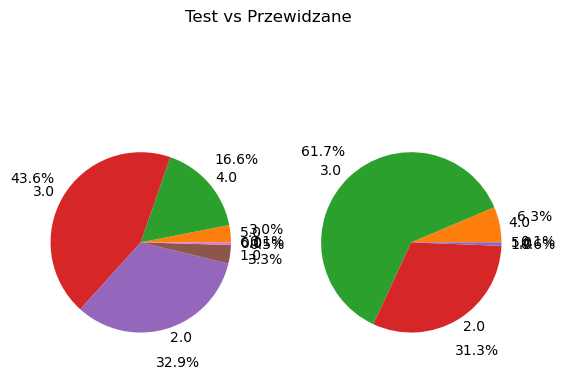

In [46]:
y_pred = model.predict(X_test_trans)
klasy_procent_plot(y_test, y_pred, "Test vs Przewidzane")

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Widzimy, że jest trochę lepiej, funkcja błędu jest mniejsza, dokładność też się zwiększyła, nawet pojawiły się klasy, których wcześniej nie przewidywaliśmy. Istotnie, poruszę kwestie interpretowania wyników troszkę dalej, bo jest to niesłychanie ważna sprawa w tym problemie

In [47]:
y_test_show = pd.DataFrame({'Real':y_test,'Predicted':y_pred}).reset_index(drop=True).sample(10)
pd.concat([y_test_show.loc[y_test_show['Real'] == 5].sample(3), y_test_show.loc[y_test_show['Real'] == 4].sample(3), y_test_show.sample(6), y_test_show.loc[y_test_show['Predicted'] == 5].sample(4)], axis = 0)

,test,pred
1282,3.0,3.0
1297,2.0,2.0
841,3.0,1.0
598,4.0,3.0
869,2.0,3.0
423,2.0,2.0
564,2.0,3.0
1066,3.0,3.0
704,5.0,3.0
76,3.0,3.0


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Nie chciałem o tym wspominać do tego momentu, bo chciałem to pokazać. Widzieliśmy, że około 70% wszystkich klas to są 3 oraz 2. A więc w miarę logiczne jest to, że model będzie najwięcej przewidywał tych wartości. Tylko istotny problem jest również w metryce, bo w klasach jest zachowany porządek. Metryka dokładności powie nam tylko czy udało nam się daną klasę przewidzieć czy nie(uogólniająć, ile mamy poprawnych przewidzeń na liczbę wszystkich próbek testowych). Tak naprawdę jeżeli model przewidzi, ocenę 5, a w rzeczywistości mamy ocenę 6, to błąd nie jest aż tak duży jak w przypadku kiedy, przewidzimy klasę 0 a w rzeczywistości mamy klasę 6. Istotna tutaj jest metryka, wydaję się, że średni błąd kwadratowy poradzi sobie dobrze, bo wyliczy nam on odległość tych punktów od siebie (i tak ja będę robił, to oczywiście nie ma być najbardziej optymalna metryka, ale dość dobra, żeby zobaczyć jak bardzo "rozjeżdzamy" się z naszymi przewidywaniami). Słowami komentarza, można zastosować taką metrykę jak "Quadratic Weighted Kappa (QWK)", ona również nadałaby się do tego problemu.

### <span style="color:#ff668c">Regresja liniowa jako klasyfikator</span>

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Ciekawy koncept, który podpowiedział mi kolega, aby spróbować, bo ten problem też możemy traktować jako pewnego rodzaju problem regresji, wtedy nasz model w głębszej sferze działa lekko inaczej, gdyż nie patrzy tylko czy zgadzają się klasy, ale stara się zminimalizować odległość między tymi przewidywaniami w jak najlepszym stopniu, a więc przewidzenie 6, kiedy w rzeczywistości mamy 0 nie będzie równoważne jak z przypadku klasyfikacji. Regressor zazwyczaj używa MSE jako funckji błędu, gdzie klasyfikator używa entropii krzyżowej w naszym przypadku do klasyfikacji kategorycznej. A więc pochodna tych funkcji jest znacznie inna.

In [35]:
best_degree = (0,-1)
for degree in range(1,7):
    transformer = PolynomialFeatures(degree = degree, include_bias = False)
    X_train_trans = transformer.fit_transform(X_train.values)

    model = Ridge()
    model.fit(X_train_trans, y_train)
    
    X_test_trans = transformer.fit_transform(X_test.values)
    score = model.score(X_test_trans, y_test)
    print(f"Wynik R^2 dla modelu o stopniu {degree}: {score:.5f}")
    if best_degree[1] < score:
        best_degree = (degree,score)

Wynik R^2 dla modelu o stopniu 1: 0.21866
Wynik R^2 dla modelu o stopniu 2: 0.26876
Wynik R^2 dla modelu o stopniu 3: 0.29094
Wynik R^2 dla modelu o stopniu 4: 0.31273
Wynik R^2 dla modelu o stopniu 5: 0.32832
Wynik R^2 dla modelu o stopniu 6: 0.32925


In [38]:
model = Ridge()

# trenujemy
transformer = PolynomialFeatures(degree = best_degree[0], include_bias = False)
X_train_trans = transformer.fit_transform(X_train.values)
model.fit(X_train_trans, y_train)

# przewidujemy
X_test_trans = transformer.fit_transform(X_test.values)
y_pred = model.predict(X_test_trans)
y_pred = list(map(round,y_pred))
score2 = accuracy_score(y_test, y_pred)
print(f"Wynik błędu dla modelu o stopniu {best_degree[0]}: {root_mean_squared_error(y_pred,y_test):.5f}")
print(f"Dokładność modelu o stopniu {best_degree[0]}: {score2:.5f}")

Wynik błędu dla modelu o stopniu 6: 0.78250
Dokładność modelu o stopniu 6: 0.52923


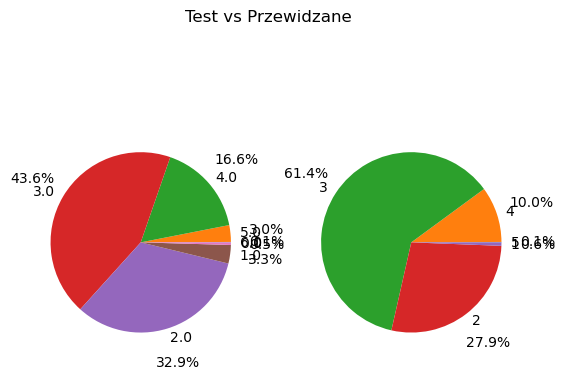

In [39]:
klasy_procent_plot(y_test, y_pred, "Test vs Przewidzane")

In [23]:
pd.DataFrame({'test':y_test,'pred':y_pred}).reset_index(drop=True).sample(10)

,test,pred
1140,3.0,2
784,3.0,2
189,2.0,2
1208,2.0,2
46,2.0,3
834,3.0,2
531,4.0,4
1032,5.0,3
300,3.0,3
494,4.0,3


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Jest lepiej niz w przypadku regresji logistycznej, czy znacznie lepiej? Raczej nie, ale widzimy, większe zróżnicowanie pośród naszych klas, więc można powiedzieć, że moja teoria, że powinno to działać troszkę lepiej sprawdziła się :)

### <span style="color:#ff668c">Drzewa Decyzyjne</span>

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Jak dla regresji problem niezbalansowanych klas stanowi problem, tak dla drzewa decyzyjnego, jest on o wiele mniejszy. Przynajmniej w teorii powinien on poradzić sobie lepiej niż nasze poprzednie modele w tym zadaniu 

In [51]:
model = DecisionTreeClassifier(max_depth=15)
model.fit(X_train, y_train)
print(f"Głębokość drzewa: {model.get_depth()}\nBłąd trenujący:{model.score(X_train, y_train):.5f}")

Głębokość drzewa: 15
Błąd trenujący:0.92977


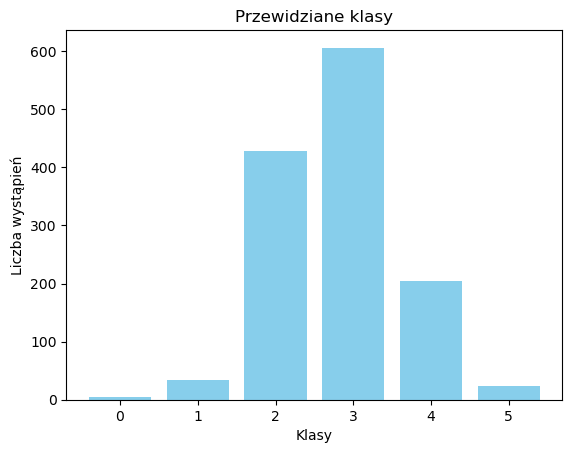

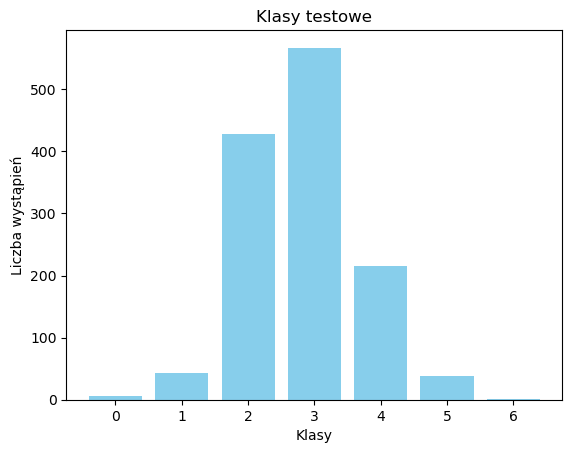

Dokładność modelu wynosi: 0.55308
Wynik błędu dla modelu: 0.88752


In [52]:
y_pred = model.predict(X_test)
y_test_show = pd.DataFrame(y_test, columns=["Real"], )
y_test_show['Predicted'] = y_pred
y_test_show.reset_index(drop=True, inplace=True)

klasy_slupki(y_pred, "Przewidziane klasy")
klasy_slupki(y_test, "Klasy testowe")
print(f"Dokładność modelu wynosi: {model.score(X_test, y_test):.5f}")
print(f"Wynik błędu dla modelu: {root_mean_squared_error(y_pred,y_test):.5f}")

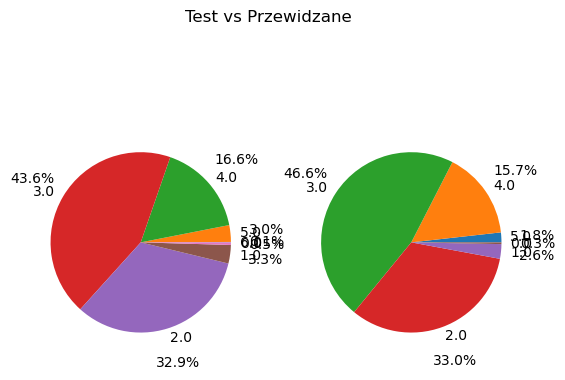

In [53]:
klasy_procent_plot(y_test, y_pred, "Test vs Przewidzane")

In [49]:
pd.concat([y_test_show.loc[y_test_show['Real'] == 5].sample(3), y_test_show.loc[y_test_show['Real'] == 4].sample(3), y_test_show.sample(6), y_test_show.loc[y_test_show['Predicted'] == 5].sample(4)], axis = 0)

,Real,Predicted
964,5.0,4.0
272,5.0,3.0
572,5.0,3.0
791,4.0,3.0
1246,4.0,3.0
396,4.0,3.0
1092,4.0,4.0
314,3.0,2.0
6,3.0,3.0
798,5.0,4.0


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Widzimy, znaczą poprawę jeśli chodzi o rozpoznawanie klas, bo rzeczywiście mamy teraz rozkład klas przewidzianych przypomijący to co mamy w testowym zbiorze(ale pomimo faktu, że klasy się rozkładają mniej więcej tak samo, to drzewo źle się nauczyło), ale jest problem taki, że model i tak osiąga słąbą dokładność oraz słaby RMSE, średnio odbiega na mniej więcej jedną wartość(0.84) w każdej próbce. Pocieszające jest to, że teraz te klasy "ekstremum" są przewidywane i czasem, dają w miarę spójne wyniki(oczywiście to i tak, jest niedokładne i nie pomijam tego faktu, na powyższej próbce ładnie to widać, że czasami bardzo odbiegamy od rzeczywistości).

### <span style="color:#ff668c">Drzewa Decyzyjne z AdaBoost</span>

> 📝 <span style="color:#b3b3cc">Komentarz: </span> Fakt, że drzewa decyzyjne dają słabe wyniki pod względem dokładności może świadczyć, że możemy mieć dużo trudnych próbek do sklasyfikowania. Zobaczmy więc czy użycie AdaBoost, poprawi nasze przewidywania

In [54]:
from sklearn.ensemble import AdaBoostClassifier

# Tworzenie słabego klasyfikatora (stump decyzyjny)
base_estimator = DecisionTreeClassifier(max_depth=6, random_state=42)

# Tworzenie klasyfikatora AdaBoost
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=1300, random_state=42, algorithm='SAMME')

# Trenowanie modelu
adaboost.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = adaboost.predict(X_test)

# Ocena modelu
acc_test = accuracy_score(y_test, y_pred)
acc_train = accuracy_score(y_train, adaboost.predict(X_train))
print(f"Trenowana dokładność: {acc_train:.5f}")
print(f"Testowa dokładność: {acc_test:.5f}")
print(f"Wartość funkcji błędu(root_mean_squared_error): {root_mean_squared_error(y_test, y_pred):.5f}")

Trenowana dokładność: 0.95016
Testowa dokładność: 0.61308
Wartość funkcji błędu(root_mean_squared_error): 0.72959


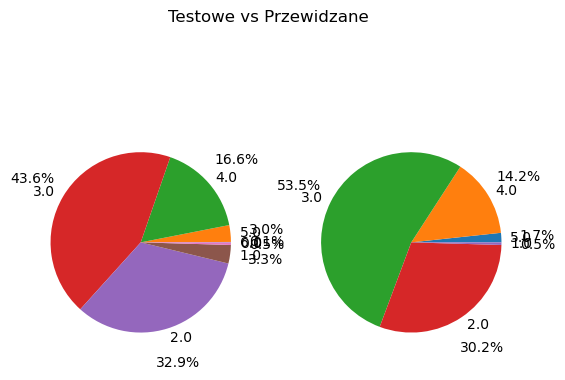

In [55]:
klasy_procent_plot(y_test,y_pred, "Testowe vs Przewidzane")

In [57]:
y_test_show = pd.DataFrame({"Real":y_test,"Predicted":y_pred}).reset_index(drop=True)
pd.concat([y_test_show.loc[y_test_show['Real'] == 5].sample(3), y_test_show.loc[y_test_show['Real'] == 4].sample(3), y_test_show.sample(6), y_test_show.loc[y_test_show['Predicted'] == 5].sample(4)], axis = 0)

,Real,Predicted
431,5.0,5.0
192,5.0,5.0
306,5.0,5.0
252,4.0,3.0
1143,4.0,3.0
1129,4.0,3.0
216,2.0,3.0
901,3.0,3.0
1135,3.0,3.0
875,2.0,2.0


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Myśle, że tutaj juz mogę z czystym sumieniem powiedzieć, że mamy zauważalną poprawę, nasz RMSE, zmniejszył się znacznie, ponadto dokładnośc jest jak narazie najlepsza sposrób wszystkich modeli. Widzimy, że przewidzanie klasy mają mniejsze odchylenie od siebie nawzajem. Wygląda to dobrze! (nie przejmujemy się tym, że rozkład klas jest lekko odbiegający od tego co w zbiorze testowym, gdyż przynajmnien w tych klasach, które są mamy dobrze przewidziane wartości, a nie tak jak w przypadku modelu powyżej, wartości, ktore często znacznie odbiegają od danej klasy)

### <span style="color:#ff668c">Sieć Neuronowa jako klasyfikator</span>

In [75]:
X_copy = X.copy()
for col in X.columns:
    X_copy[col] += np.abs(X_copy[col].min()) + 1
    
X_train, X_test, y_train, y_test = train_test_split(X_copy,y_trans, stratify=y_trans, test_size=0.2, shuffle=True)

transformer = OneHotEncoder(sparse_output=False)
y_train_OH = pd.DataFrame(transformer.fit_transform(y_train.values.reshape(-1,1)))
y_test_OH = pd.DataFrame(transformer.fit_transform(y_test.values.reshape(-1,1)))

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train_OH, random_state=42, stratify=y_train, test_size=0.2)

In [76]:
earlyStopping = keras.src.callbacks.early_stopping.EarlyStopping(monitor='val_loss', patience=30, verbose=0, restore_best_weights=True)

model = create_model(lay_num=5, lay_neuron=80)
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=100,verbose=0, callbacks=[earlyStopping])

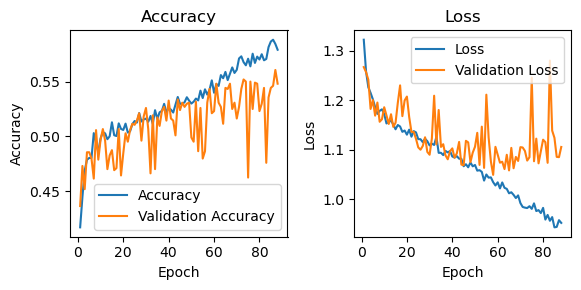

------------------------------
 Accuracy: 0.5790233612060547
 Validation Accuracy: 0.5480769276618958
 Loss: 0.9520784616470337
 Validation Loss: 1.1054081916809082
 ------------------------------


In [77]:
plot_history(hist)

In [78]:
score = model.evaluate(X_test, y_test_OH, verbose=0)
y_pred = model.predict(X_test, verbose=0)
y_pred_show = np.argmax(y_pred, axis=1)
print(f"Funckja straty(cateogrical_crossentropy): {score[0]:.5f}\nDokładność modelu:{score[1]:.5f}")
print(f"Wynik błędu(root_mean_squared_error): {root_mean_squared_error(y_pred_show,y_test):.5f}")

Funckja straty(cateogrical_crossentropy): 1.08045
Dokładność modelu:0.53692
Wynik błędu(root_mean_squared_error): 0.80240


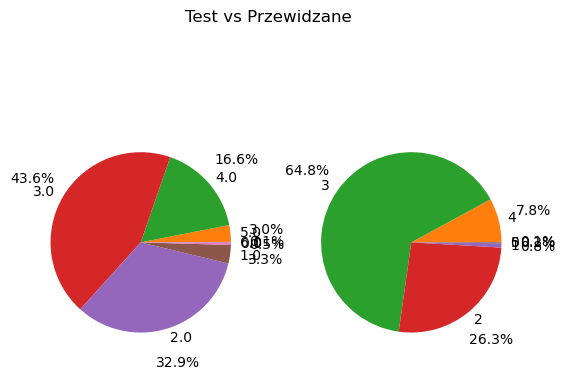

In [79]:
klasy_procent_plot(y_test, y_pred_show, "Test vs Przewidzane")

In [80]:
y_pred_show =pd.DataFrame({"test":y_test,"pred":y_pred_show}).reset_index(drop=True)
pd.concat([y_test_show.loc[y_test_show['Real'] == 5].sample(3), y_test_show.loc[y_test_show['Real'] == 4].sample(3), y_test_show.sample(6), y_test_show.loc[y_test_show['Predicted'] == 5].sample(4)], axis = 0)

,Real,Predicted
326,5.0,5.0
572,5.0,3.0
573,5.0,3.0
1120,4.0,4.0
998,4.0,4.0
512,4.0,4.0
232,2.0,2.0
645,4.0,4.0
849,4.0,4.0
390,3.0,3.0


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Tutaj jeszcze, dla testów wytrenowałem sieć neuronową. Podobnie jak dla modelów liniowych, będzie tutaj regresor oraz klasyfikator. Widzimy, że nie jest znacznie lepiej niż w przypadku modeli regresji liniowej, ale i tak drzewa decyzyjne z AdaBoost radzą sobie lepiej

### <span style="color:#ff668c">Sieć neuronowa jako hybryda</span>

In [81]:
X_copy = X.copy()
for col in X.columns:
    X_copy[col] += np.abs(X_copy[col].min()) + 1
    
X_train, X_test, y_train, y_test = train_test_split(X_copy,y_trans, stratify=y_trans, test_size=0.2, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, random_state=42, stratify=y_train, test_size=0.2)

In [82]:
model = create_model_regressor(lay_num=5, lay_neuron=80)
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100, batch_size=10, verbose=0, callbacks=[earlyStopping])

In [83]:
score = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred = list(map(round,y_pred.flatten()))
print(f"Funckja straty(mean_squared_error): {score:.5f}")
print(f"Funckja błędu(root_mean_squared_error): {root_mean_squared_error(y_pred,y_test):.5f}")
print(f"Dokładność modelu: {accuracy_score(y_test, y_pred):.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
Funckja straty(mean_squared_error): 0.54092
Funckja błędu(root_mean_squared_error): 0.80096
Dokładność modelu: 0.51615


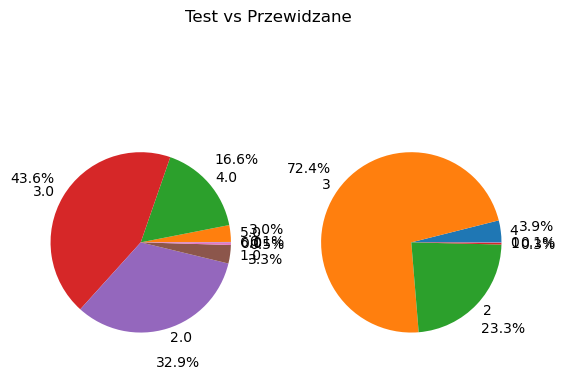

In [84]:
klasy_procent_plot(y_test, y_pred, "Test vs Przewidzane")

In [85]:
y_pred_show = pd.DataFrame({"test":y_test,"pred":y_pred}).reset_index(drop=True)
pd.concat([y_test_show.loc[y_test_show['Real'] == 5].sample(3), y_test_show.loc[y_test_show['Real'] == 4].sample(3), y_test_show.sample(6), y_test_show.loc[y_test_show['Predicted'] == 5].sample(4)], axis = 0)

,Real,Predicted
342,5.0,3.0
192,5.0,5.0
326,5.0,5.0
1070,4.0,4.0
914,4.0,4.0
968,4.0,4.0
595,4.0,4.0
1064,4.0,4.0
795,3.0,4.0
210,3.0,3.0


> 📝 <span style="color:#b3b3cc">Komentarz: </span> Wyniki bardzo podobne jak do sieci neuronowej, która jest klasyfikatorem, mamy niedużą rozbieżność między dokładnością oraz RMSE. 

## <span style="color:#ffb366">Wnioski:</span>
* Najlepiej poradził sobie algorytm AdaBoost
* Zbiór okazał się bardzo trudny do robienia tego typu klasyfikacji
* Prościej byłoby sprowadzić ten problem do klasyfikacji binarnej, wtedy *prognozuję* iż wyniki byłyby dużo lepsze :)
* Wydaję mi się, że w końcowym rozrachunku, dość dobrze udało mi się zaradzić z tym problemem i wyniki są optymalnie dobre